### Dependencies

In [1]:
%matplotlib inline
import numpy as np # Scientific computing 
import matplotlib.pyplot as plt # Plotting 
from astropy.stats import LombScargle # Basic Astronomy functions
import pandas as pd # Dataframe to store csv file content
import upsilon # Machine Learnign classification of light curve
import seaborn # Additional plotting
seaborn.set() # Set aesthetic parameters in one step.
from scipy import signal

-------------------------------
* WARNING: No pyFFTW detected *
-------------------------------


### Process Data

In [2]:
# Data from AAVSO
star = "CSCas"

# Load the data from csv file
light_curve = pd.read_csv("ftp://ftp.astrouw.edu.pl/ogle/ogle3/OIII-CVS/lmc/t2cep/phot/I/OGLE-LMC-T2CEP-002.dat",
                          sep="\s+", names=["JD", "Magnitude", "Uncertainty"])

# Creating numpy array from pandas dataframe
mag = np.array(light_curve.fillna(0).Magnitude.tolist())
time = np.array(light_curve.fillna(0).JD.tolist())
err = np.array(light_curve.fillna(0).Uncertainty.tolist()) #fillna(0) replaces NaN with 0

### Raw Data Plot

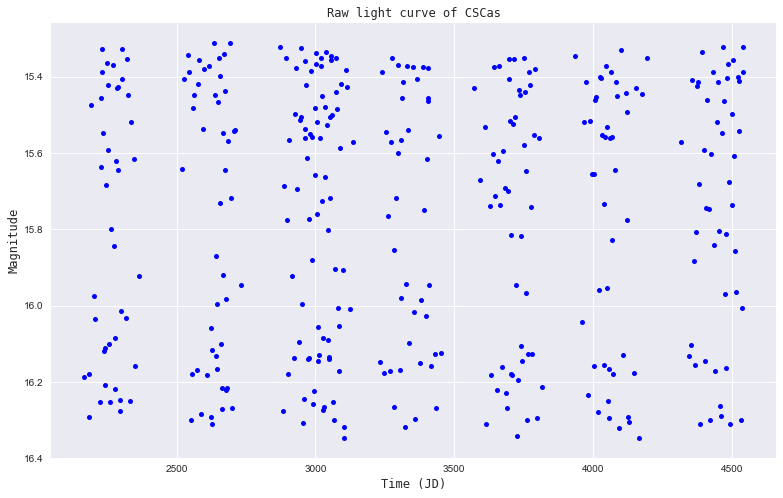

In [3]:
# Plot the raw data.
plt.figure(figsize=(13,8))
plt.plot(time, mag, marker='o', ls='None', ms=5, c='b')
plt.gca().invert_yaxis()
plt.xlabel("Time (JD)", size='medium', family = 'monospace')
plt.ylabel("Magnitude", size='medium', family = 'monospace')
plt.title("Raw light curve of " +star, size='medium', family = 'monospace')
plt.show()

### Lomb-Scargle Periodogram

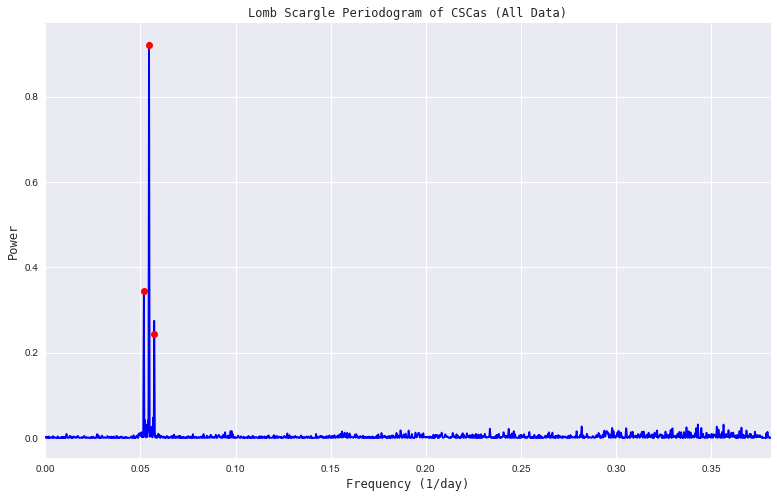

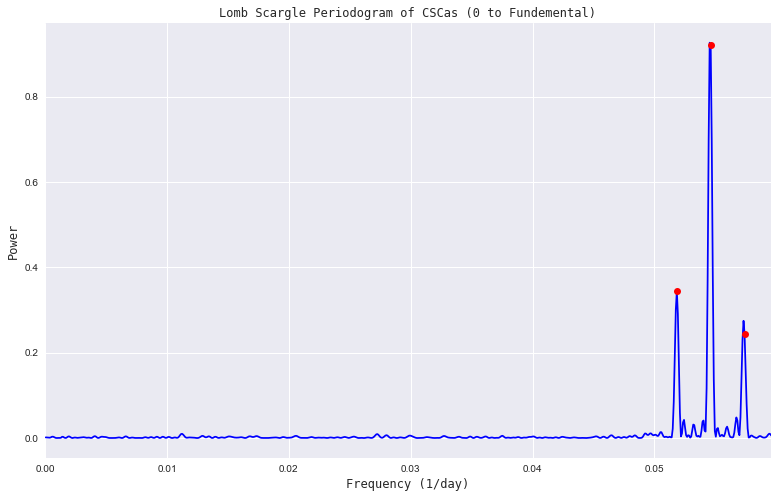

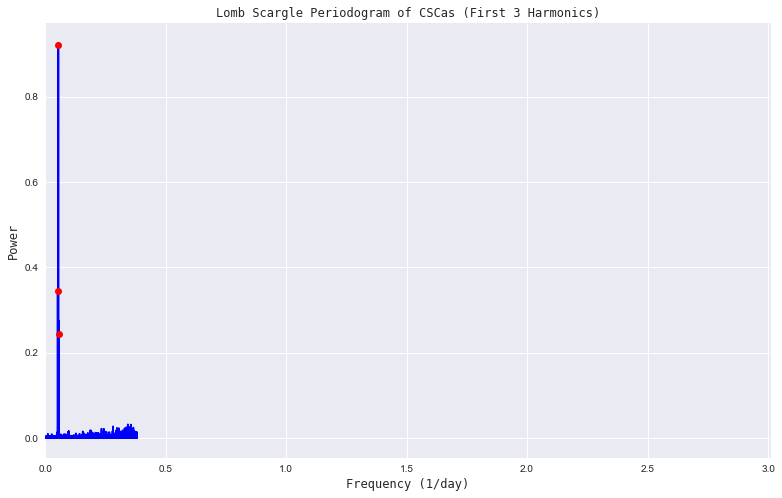

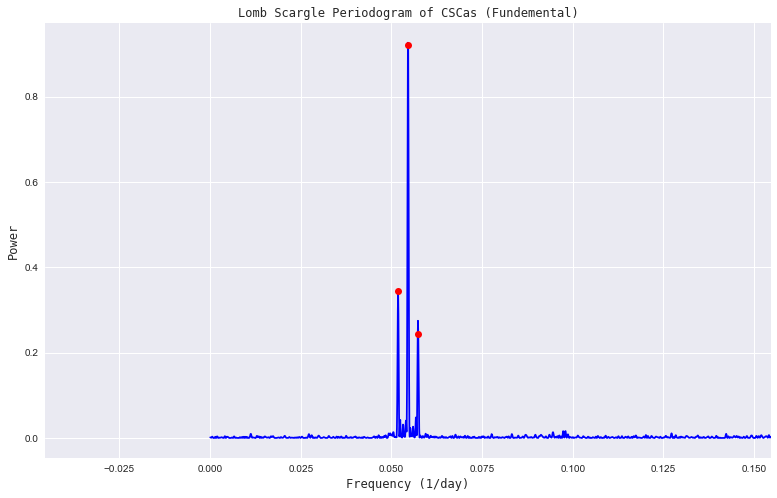

In [33]:
# If undertainty column in data is 0 then manually give uncertainity value to all points.
#err = 0.01

# nterms (1 by default) controls how many Fourier terms are used in the model.
frequency, power = LombScargle(time, mag, err, nterms = 1).autopower()
peakind = signal.find_peaks_cwt(power, np.arange(1,10))

# Remove found maxima on noise
peakind = [ind for ind in peakind if power[ind]>0.04]
# Remove found maxima that are essentially on top of each other
temp = []
for n in range(1, len(peakind)):
    freq_a = frequency[peakind][n-1]
    freq_b = frequency[peakind][n]
    freq_dif = freq_b - freq_a
    threshold = 0.001
    if n==1 and (freq_dif)>threshold:
        temp.append(peakind[n-1])
    if (freq_dif)>threshold:
        temp.append(peakind[n])
peakind = temp

# Sort peaks from largest power to smallest power and their frequencies
powers = sorted(power[peakind], key = lambda x:x, reverse=True)
freqs = [frequency[peakind][power[peakind].tolist().index(x)] for x in powers]


fund_frequency = frequency[np.argmax(power)]
plot_ranges = ((" (All Data)", [min(frequency), max(frequency)]),
               (" (0 to Fundemental)", [0, fund_frequency+0.005]),
               (" (First 3 Harmonics)", [0, 3.01]),
               (" (Fundemental)", [fund_frequency-0.1, fund_frequency+0.1]))
for (title, r) in plot_ranges:
    plt.figure(figsize=(13,8))
    plt.plot(frequency, power, c='b')
    plt.plot(frequency[peakind], power[peakind], marker='o', ls='None', c='r')
    plt.xlabel("Frequency (1/day)", size='medium', family = 'monospace')
    plt.ylabel("Power", size='medium', family = 'monospace')
    plt.title("Lomb Scargle Periodogram of " +star +title, size='medium', family = 'monospace')
    plt.xlim(r)
    plt.savefig(star+title+'_power.png')
    plt.show()

### Phase Plot with Best-Fit Sinusoid 

In [5]:
print(frequency[peakind][5]-frequency[peakind][0])
best_frequency = fund_frequency

for freq in freqs:
    phase_fit = np.linspace(0, 1)
    y_fit = LombScargle(time, mag, err, nterms=1).model(phase_fit/freq, frequency=freq)
    lower_amp = [max(y_fit) for x in y_fit]
    upper_amp = [min(y_fit) for x in y_fit]
    amp = (lower_amp[0] - upper_amp[0])/2
    phase = (time*freq)%1

    fig, ax = plt.subplots(figsize=(13, 8))
    ax.plot(phase_fit, y_fit, color='black', zorder=10)
    ax.errorbar(phase, mag, err, fmt='o', mew=0, capsize=0, elinewidth=1.5, c='darkorange')
    ax.plot(phase_fit, y_fit, color='black')
    ax.plot(phase_fit, upper_amp, color='b')
    ax.plot(phase_fit, lower_amp, color='b')
    ax.invert_yaxis()
    plt.xlim([0,1])
    plt.ylim([max(mag)+0.3, min(mag)-0.3])
    ax.set(xlabel='Phase',
           ylabel='Magnitude',
           title='Phased Data at Frequency={0:.3f} and harmonic-ness={1:.3f}'.format(freq, freq/best_frequency))
    ax.annotate('Upper Amp={0:.2f} \nLower_amp={1:.2f} \nAmpliude={2:.2f}'.format(upper_amp[0], lower_amp[0], amp),
                xy=(0.8, min(mag)-0.15))
    plt.show()

IndexError: index 5 is out of bounds for axis 0 with size 0

### Classification

$\textbf{UPSILoN: AUtomated Classification for Periodic Variable Stars using MachIne LearNing.}$ This software package classifies a light curve into a class of a periodic variable star in an automatic manner. It can be applied to light curves from optical surveys regardless of survey-specific characteristics (e.g., photometric accuracy, sampling rate, duration, etc.) as long as the light curves satisfy a few broad conditions:

– it contains at least a few tens of data points that sample the characteristic variability well;

– the observation duration is more than a few weeks;

– the light curve is obtained in an optical band.

If multiple optical bands are available, UPSILoN can classify them separately. It does not use – or rely on – color information. UPSILoN is currently trained to classify into six types of periodic variables: δ Scuti, RR Lyrae, Cepheid, Type II Cepheid, eclipsing binary, long-period variable, and their subclasses. UPSILoN can also separate non-variables from these periodic variables, which is important because the majority of light curves from most time-series surveys are non-variables.

#### UPSILoN CLassification
$\textit{Variable Star Type}$: Long-Period Variables (LPV), Cepheid, Type II Cepheid, RR Lyrae, δ Scuti, and eclipsing binary.

$\textit{Subclass}$: Ex. Mira

$\textit{Phase of Evolution}$: Ex. asymptotic giant branch (AGB)

$\textit{Spectral Type}$: Ex. C

In [ ]:
# time, mag, err are numpy arrays.
def classify_lightcurve(time, mag, err):
    # Refine data. This removes fluctuated data points in magnitudes.
    #date, mag, err = upsilon.utils.sigma_clipping(date, mag, err, threshold=3, iteration=1)
    
    # Load a classification model.
    rf_model = upsilon.load_rf_model()

    # Extract features
    e_features = upsilon.ExtractFeatures(time, mag)
    e_features.run()
    features = e_features.get_features()

    # Classify the light curve
    label, probability, flag = upsilon.predict(rf_model, features)
    print('Class: ',label,'\n', 
          'Probability: ',probability ,'\n', 
          'Flag: ',flag,'\n', # (0: successful classification) and (1: Suspicious classification)
          'Best Period: ',features['period'])
        
classify_lightcurve(time, mag, err)